In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
from torchvision import models

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
class ImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, max_attempts=5):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.max_attempts = max_attempts  # Limit attempts to avoid infinite loops

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        attempts = 0
        while attempts < self.max_attempts:
            try:
                # Get image path
                img_name = os.path.join(self.img_dir, f"{int(self.annotations.iloc[idx]['imagefile']):06}.jpg")

                image = Image.open(img_name).convert("RGB")

                # Get label
                label = torch.tensor(int(self.annotations.iloc[idx]['ID']))

                # Apply transformation if available
                if self.transform:
                    image = self.transform(image)

                return image, label

            except FileNotFoundError:
                # Handle missing file and attempt to move to the next image
                print(f"File not found: {self.annotations.iloc[idx]['imagefile']}. Skipping...")
                idx = (idx + 1) % len(self.annotations)  # Move to the next image
                attempts += 1  # Count this as a failed attempt

        # If the loop exceeds max_attempts, raise an error
        raise RuntimeError(f"Exceeded maximum attempts to load valid images. Check your dataset.")

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    # transforms.ColorJitter(contrast=5, brightness=5),  # Adjust contrast and brightness
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),  # Apply Gaussian blur
    transforms.ToTensor(),
   # transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)), # Resize images to the size expected by ResNet

    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard normalization for ImageNet
])


In [4]:
import os
import csv
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/mydrive')

# Define the paths to the folders and CSV file
drive_path = '/content/mydrive/MyDrive/'  # Modify as needed
check_folder = os.path.join(drive_path, 'check')
plainsing_folder = os.path.join(drive_path, 'plainmulti')
csv_file_path = os.path.join(check_folder, 'idplainmulti_mapped.csv')

batch_size= 20
num_workers = 0

# Specify the root directory for images and the CSV file containing class labels and filenames
root_dir = '/content/mydrive/MyDrive/check/plainmulti'  # Change this to your directory
csv_file = '/content/mydrive/MyDrive/check/idplainmulti_mapped.csv'  # CSV file containing ids (labels) and image filenames

valid_size = 0.2

csv_file =csv_file_path  # Path to CSV with image file names and labels
img_dir = plainsing_folder  # Path to image folder
dataset = ImageDataset(csv_file, root_dir, transform=transform)

# Split dataset into validation and test sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
    num_workers=num_workers)

Mounted at /content/mydrive


In [5]:
batch_size = 16
#dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [6]:
num_classes = 28 # 107 unique tiger ids



In [ ]:
# # images, labels = next(iter(dataloader))
# # print(images.shape, labels.shap
# dataiter = iter(train_loader)
# data = next(dataiter)
# images, labels = data
# print(images.shape, labels.shape)

# **[ALEXNET Code training](https://)**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 175MB/s]


Epoch 1 finished, Train Loss: 3.3669
Epoch 1 finished, Validation Loss: 2.4540
Best model saved with validation loss: 2.4540
Epoch 2 finished, Train Loss: 1.8782
Epoch 2 finished, Validation Loss: 1.7103
Best model saved with validation loss: 1.7103
Epoch 3 finished, Train Loss: 1.4618
Epoch 3 finished, Validation Loss: 1.6125
Best model saved with validation loss: 1.6125
Epoch 4 finished, Train Loss: 1.4411
Epoch 4 finished, Validation Loss: 1.6554
Epoch 5 finished, Train Loss: 1.1440
Epoch 5 finished, Validation Loss: 1.4942
Best model saved with validation loss: 1.4942
Epoch 6 finished, Train Loss: 1.0470
Epoch 6 finished, Validation Loss: 1.5822
Epoch 7 finished, Train Loss: 0.9229
Epoch 7 finished, Validation Loss: 1.9897
Epoch 8 finished, Train Loss: 0.8244
Epoch 8 finished, Validation Loss: 1.7945
Epoch 9 finished, Train Loss: 1.1402
Epoch 9 finished, Validation Loss: 1.9116
Epoch 10 finished, Train Loss: 1.0790
Epoch 10 finished, Validation Loss: 1.7989
Epoch 11 finished, Train

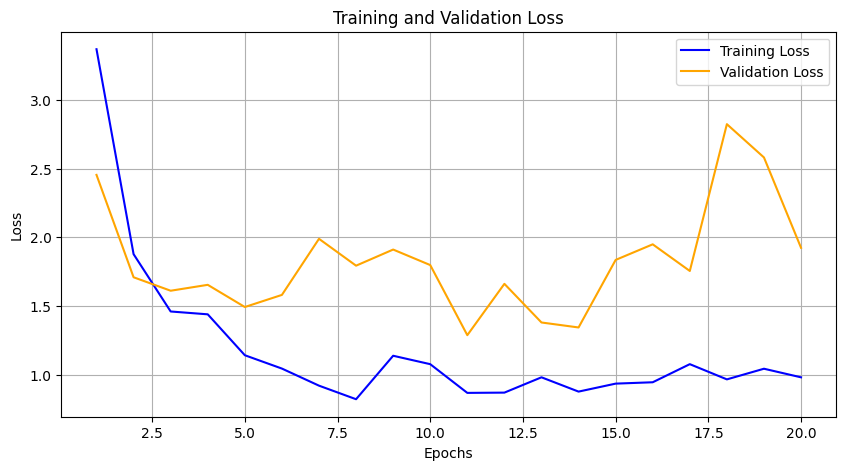

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import os

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained AlexNet model
model = models.alexnet(pretrained=True)

# Freeze all layers except the final fully connected layer
for param in model.features.parameters():
    param.requires_grad = False  # Freeze feature extraction layers

# Modify the final fully connected layer for 28 classes
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 28)

# Move the model to the GPU
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

num_epochs = 20
train_loss_list = []  # To store training loss
val_loss_list = []    # To store validation loss
best_val_loss = float('inf')  # Initialize with infinity to track the best validation loss
best_model_path = "AlexNetbest_model.pth"  # File to store the best model

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_list.append((epoch + 1, epoch_train_loss))  # Store epoch number and training loss
    print(f'Epoch {epoch+1} finished, Train Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:  # Use your validation loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(valid_loader)
    val_loss_list.append((epoch + 1, epoch_val_loss))  # Store epoch number and validation loss
    print(f'Epoch {epoch+1} finished, Validation Loss: {epoch_val_loss:.4f}')

    # Save the model if it has the best validation loss so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)  # Save the model's state dictionary
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Combine and save losses to a CSV file
loss_data = [(epoch, train_loss, val_loss) for (epoch, train_loss), (_, val_loss) in zip(train_loss_list, val_loss_list)]
df = pd.DataFrame(loss_data, columns=['Epoch', 'Train Loss', 'Validation Loss'])
df.to_csv('lossesAlexNet.csv', index=False)

print("Losses saved to 'losses.csv'.")

# Plotting the losses
epochs = [epoch for epoch, _ in train_loss_list]
train_losses = [loss for _, loss in train_loss_list]
val_losses = [loss for _, loss in val_loss_list]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plot.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


# **AlexNet Testing**

In [8]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm

# Function to calculate mAP (mean Average Precision)
def calculate_map(all_labels, all_scores, num_classes):
    mAP_scores = []
    for c in range(num_classes):
        true_labels = (all_labels == c).astype(int)
        pred_scores = all_scores[:, c]  # Scores for class c

        # Handle case where there are no positive samples
        if true_labels.sum() == 0:
            mAP_scores.append(0.0)
            continue

        ap = average_precision_score(true_labels, pred_scores)
        mAP_scores.append(ap)

    mAP = np.mean(mAP_scores)
    return mAP

# Function to evaluate the model
def evaluate_model(model, test_loader, num_classes, model_path=None):
    # Load the best model if the path is provided
    if model_path is not None:
        print(f"Loading the best model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)

    model.eval()  # Set model to evaluation mode
    top1_correct = 0
    top5_correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)  # Move images to the GPU
            labels = labels.to(device)  # Move labels to the GPU

            outputs = model(images)  # Forward pass

            # Get predicted class probabilities
            pred_scores = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)

            # Get class predictions
            _, predicted = torch.max(outputs, 1)  # Shape: (batch_size,)

            # Top-1 accuracy
            top1_correct += (predicted == labels).sum().item()
            # Top-5 accuracy
            _, top5_pred = torch.topk(outputs, 5, dim=1)
            top5_correct += (top5_pred == labels.view(-1, 1).expand_as(top5_pred)).sum().item()

            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_scores.append(pred_scores.cpu().numpy())  # Append the scores

    # Calculate accuracies
    top1_accuracy = (top1_correct / total) * 100
    top5_accuracy = (top5_correct / total) * 100

    # Concatenate all predicted scores into a 2D array
    all_scores = np.concatenate(all_scores)  # Shape: (num_samples, num_classes)

    # Calculate mean Average Precision (mAP)
    mAP = calculate_map(np.array(all_labels), all_scores, num_classes)

    print(f'Top-1 Accuracy: {top1_accuracy:.4f}')
    print(f'Top-5 Accuracy: {top5_accuracy:.4f}')
    print(f'mAP: {mAP:.4f}')

    return {
        'Top-1 Accuracy': top1_accuracy,
        'Top-5 Accuracy': top5_accuracy,
        'mAP': mAP,
    }

# Example usage
best_model_path = 'AlexNetbest_model.pth'  # Path where the best model is saved
results = evaluate_model(model, test_loader, num_classes=28, model_path=best_model_path)

# Print evaluation results
for metric, value in results.items():
    print(f'{metric}: {value:.4f}')


Loading the best model from AlexNetbest_model.pth


<ipython-input-8-60b52088d642>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
100%|██████████| 11/11 [02:16<00:00, 12.40s/it

Top-1 Accuracy: 73.7089
Top-5 Accuracy: 95.3052
mAP: 0.8163
Top-1 Accuracy: 73.7089
Top-5 Accuracy: 95.3052
mAP: 0.8163


## **ResNet18 Training**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s]


Epoch 1 finished, Train Loss: 3.0216
Epoch 1 finished, Validation Loss: 2.6038
Best model saved with validation loss: 2.6038
Epoch 2 finished, Train Loss: 1.9823
Epoch 2 finished, Validation Loss: 2.0895
Best model saved with validation loss: 2.0895
Epoch 3 finished, Train Loss: 1.4115
Epoch 3 finished, Validation Loss: 1.7313
Best model saved with validation loss: 1.7313
Epoch 4 finished, Train Loss: 1.1526
Epoch 4 finished, Validation Loss: 1.5362
Best model saved with validation loss: 1.5362
Epoch 5 finished, Train Loss: 0.9490
Epoch 5 finished, Validation Loss: 1.4092
Best model saved with validation loss: 1.4092
Epoch 6 finished, Train Loss: 0.8015
Epoch 6 finished, Validation Loss: 1.3552
Best model saved with validation loss: 1.3552
Epoch 7 finished, Train Loss: 0.6965
Epoch 7 finished, Validation Loss: 1.3080
Best model saved with validation loss: 1.3080
Epoch 8 finished, Train Loss: 0.6181
Epoch 8 finished, Validation Loss: 1.2671
Best model saved with validation loss: 1.2671


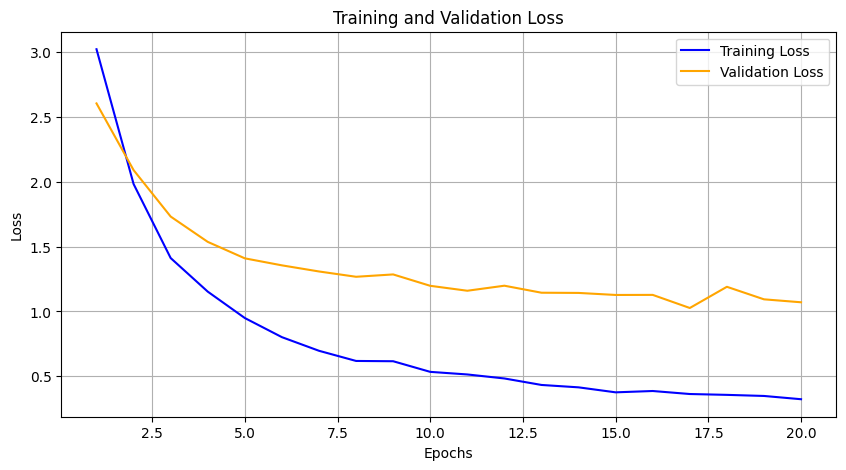

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import os

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained ResNet model
model = models.resnet18(pretrained=True)  # You can also use resnet50 or resnet101, etc.

# Freeze all convolutional layers (i.e., feature extractor)
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer for 28 output classes
num_classes = 28
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the GPU
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

num_epochs = 20
train_loss_list = []  # To store training loss
val_loss_list = []    # To store validation loss
best_val_loss = float('inf')  # Initialize with infinity to track the best validation loss
best_model_path = "ResNetbest_model.pth"  # File to store the best model

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_list.append((epoch + 1, epoch_train_loss))  # Store epoch number and training loss
    print(f'Epoch {epoch+1} finished, Train Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:  # Use your validation loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(valid_loader)
    val_loss_list.append((epoch + 1, epoch_val_loss))  # Store epoch number and validation loss
    print(f'Epoch {epoch+1} finished, Validation Loss: {epoch_val_loss:.4f}')

    # Save the model if it has the best validation loss so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)  # Save the model's state dictionary
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Combine and save losses to a CSV file
loss_data = [(epoch, train_loss, val_loss) for (epoch, train_loss), (_, val_loss) in zip(train_loss_list, val_loss_list)]
df = pd.DataFrame(loss_data, columns=['Epoch', 'Train Loss', 'Validation Loss'])
df.to_csv('lossesResNet.csv', index=False)

print("Losses saved to 'losses.csv'.")

# Plotting the losses
epochs = [epoch for epoch, _ in train_loss_list]
train_losses = [loss for _, loss in train_loss_list]
val_losses = [loss for _, loss in val_loss_list]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plot.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


# **ResNet Testing**

In [10]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm

# Function to calculate mAP (mean Average Precision)
def calculate_map(all_labels, all_scores, num_classes):
    mAP_scores = []
    for c in range(num_classes):
        true_labels = (all_labels == c).astype(int)
        pred_scores = all_scores[:, c]  # Scores for class c

        # Handle case where there are no positive samples
        if true_labels.sum() == 0:
            mAP_scores.append(0.0)
            continue

        ap = average_precision_score(true_labels, pred_scores)
        mAP_scores.append(ap)

    mAP = np.mean(mAP_scores)
    return mAP

# Function to evaluate the model
def evaluate_model(model, test_loader, num_classes, model_path=None):
    # Load the best model if the path is provided
    if model_path is not None:
        print(f"Loading the best model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)

    model.eval()  # Set model to evaluation mode
    top1_correct = 0
    top5_correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)  # Move images to the GPU
            labels = labels.to(device)  # Move labels to the GPU

            outputs = model(images)  # Forward pass

            # Get predicted class probabilities
            pred_scores = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)

            # Get class predictions
            _, predicted = torch.max(outputs, 1)  # Shape: (batch_size,)

            # Top-1 accuracy
            top1_correct += (predicted == labels).sum().item()
            # Top-5 accuracy
            _, top5_pred = torch.topk(outputs, 5, dim=1)
            top5_correct += (top5_pred == labels.view(-1, 1).expand_as(top5_pred)).sum().item()

            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_scores.append(pred_scores.cpu().numpy())  # Append the scores

    # Calculate accuracies
    top1_accuracy = (top1_correct / total) * 100
    top5_accuracy = (top5_correct / total) * 100

    # Concatenate all predicted scores into a 2D array
    all_scores = np.concatenate(all_scores)  # Shape: (num_samples, num_classes)

    # Calculate mean Average Precision (mAP)
    mAP = calculate_map(np.array(all_labels), all_scores, num_classes)

    print(f'Top-1 Accuracy: {top1_accuracy:.4f}')
    print(f'Top-5 Accuracy: {top5_accuracy:.4f}')
    print(f'mAP: {mAP:.4f}')

    return {
        'Top-1 Accuracy': top1_accuracy,
        'Top-5 Accuracy': top5_accuracy,
        'mAP': mAP,
    }

# Example usage
best_model_path = 'ResNetbest_model.pth'  # Path where the best model is saved
results = evaluate_model(model, test_loader, num_classes=28, model_path=best_model_path)

# Print evaluation results
for metric, value in results.items():
    print(f'{metric}: {value:.4f}')


<ipython-input-10-b0828c947b31>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Loading the best model from ResNetbest_model.pth


100%|██████████| 11/11 [00:01<00:00,  7.22it/s]

Top-1 Accuracy: 69.4836
Top-5 Accuracy: 97.6526
mAP: 0.7857
Top-1 Accuracy: 69.4836
Top-5 Accuracy: 97.6526
mAP: 0.7857


# **VGGNet16 Training**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 98.4MB/s]


Epoch 1 finished, Train Loss: 3.6962
Epoch 1 finished, Validation Loss: 2.5062
Best model saved with validation loss: 2.5062
Epoch 2 finished, Train Loss: 2.4203
Epoch 2 finished, Validation Loss: 2.0189
Best model saved with validation loss: 2.0189
Epoch 3 finished, Train Loss: 2.2230
Epoch 3 finished, Validation Loss: 2.4127
Epoch 4 finished, Train Loss: 2.1374
Epoch 4 finished, Validation Loss: 1.7648
Best model saved with validation loss: 1.7648
Epoch 5 finished, Train Loss: 1.9756
Epoch 5 finished, Validation Loss: 2.3586
Epoch 6 finished, Train Loss: 2.3657
Epoch 6 finished, Validation Loss: 2.1745
Epoch 7 finished, Train Loss: 2.8519
Epoch 7 finished, Validation Loss: 4.1312
Epoch 8 finished, Train Loss: 3.2277
Epoch 8 finished, Validation Loss: 4.8203
Epoch 9 finished, Train Loss: 2.8750
Epoch 9 finished, Validation Loss: 1.9143
Epoch 10 finished, Train Loss: 2.7250
Epoch 10 finished, Validation Loss: 3.9256
Epoch 11 finished, Train Loss: 3.6232
Epoch 11 finished, Validation Lo

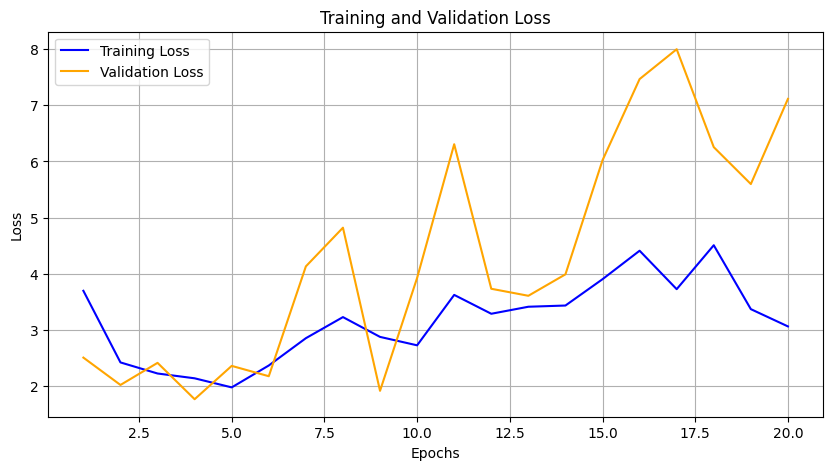

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import os

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained VGG16 model
model = models.vgg16(pretrained=True)  # You can also use vgg19

# Freeze all layers except the classifier (fully connected layers)
for param in model.features.parameters():  # Freeze feature extractor (convolutional layers)
    param.requires_grad = False

# Modify the final classifier layer for 28 output classes
num_classes = 28
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Move the model to the GPU
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

num_epochs = 20
train_loss_list = []  # To store training loss
val_loss_list = []    # To store validation loss
best_val_loss = float('inf')  # Initialize with infinity to track the best validation loss
best_model_path = "VGGNetbest_model.pth"  # File to store the best model

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_list.append((epoch + 1, epoch_train_loss))  # Store epoch number and training loss
    print(f'Epoch {epoch+1} finished, Train Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:  # Use your validation loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(valid_loader)
    val_loss_list.append((epoch + 1, epoch_val_loss))  # Store epoch number and validation loss
    print(f'Epoch {epoch+1} finished, Validation Loss: {epoch_val_loss:.4f}')

    # Save the model if it has the best validation loss so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)  # Save the model's state dictionary
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Combine and save losses to a CSV file
loss_data = [(epoch, train_loss, val_loss) for (epoch, train_loss), (_, val_loss) in zip(train_loss_list, val_loss_list)]
df = pd.DataFrame(loss_data, columns=['Epoch', 'Train Loss', 'Validation Loss'])
df.to_csv('lossesVGGNet.csv', index=False)

print("Losses saved to 'losses.csv'.")

# Plotting the losses
epochs = [epoch for epoch, _ in train_loss_list]
train_losses = [loss for _, loss in train_loss_list]
val_losses = [loss for _, loss in val_loss_list]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plot.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


# **VGGNet16 testing**`

In [12]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm

# Function to calculate mAP (mean Average Precision)
def calculate_map(all_labels, all_scores, num_classes):
    mAP_scores = []
    for c in range(num_classes):
        true_labels = (all_labels == c).astype(int)
        pred_scores = all_scores[:, c]  # Scores for class c

        # Handle case where there are no positive samples
        if true_labels.sum() == 0:
            mAP_scores.append(0.0)
            continue

        ap = average_precision_score(true_labels, pred_scores)
        mAP_scores.append(ap)

    mAP = np.mean(mAP_scores)
    return mAP

# Function to evaluate the model
def evaluate_model(model, test_loader, num_classes, model_path=None):
    # Load the best model if the path is provided
    if model_path is not None:
        print(f"Loading the best model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)

    model.eval()  # Set model to evaluation mode
    top1_correct = 0
    top5_correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)  # Move images to the GPU
            labels = labels.to(device)  # Move labels to the GPU

            outputs = model(images)  # Forward pass

            # Get predicted class probabilities
            pred_scores = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)

            # Get class predictions
            _, predicted = torch.max(outputs, 1)  # Shape: (batch_size,)

            # Top-1 accuracy
            top1_correct += (predicted == labels).sum().item()
            # Top-5 accuracy
            _, top5_pred = torch.topk(outputs, 5, dim=1)
            top5_correct += (top5_pred == labels.view(-1, 1).expand_as(top5_pred)).sum().item()

            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_scores.append(pred_scores.cpu().numpy())  # Append the scores

    # Calculate accuracies
    top1_accuracy = (top1_correct / total) * 100
    top5_accuracy = (top5_correct / total) * 100

    # Concatenate all predicted scores into a 2D array
    all_scores = np.concatenate(all_scores)  # Shape: (num_samples, num_classes)

    # Calculate mean Average Precision (mAP)
    mAP = calculate_map(np.array(all_labels), all_scores, num_classes)

    print(f'Top-1 Accuracy: {top1_accuracy:.4f}')
    print(f'Top-5 Accuracy: {top5_accuracy:.4f}')
    print(f'mAP: {mAP:.4f}')

    return {
        'Top-1 Accuracy': top1_accuracy,
        'Top-5 Accuracy': top5_accuracy,
        'mAP': mAP,
    }

# Example usage
best_model_path = 'VGGNetbest_model.pth'  # Path where the best model is saved
results = evaluate_model(model, test_loader, num_classes=28, model_path=best_model_path)

# Print evaluation results
for metric, value in results.items():
    print(f'{metric}: {value:.4f}')


Loading the best model from VGGNetbest_model.pth


<ipython-input-12-7a42a8b2567c>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
100%|██████████| 11/11 [00:01<00:00,  5.88it/

Top-1 Accuracy: 63.3803
Top-5 Accuracy: 88.7324
mAP: 0.6306
Top-1 Accuracy: 63.3803
Top-5 Accuracy: 88.7324
mAP: 0.6306


# **GOogleNet(Inveption)**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 136MB/s]


Epoch 1 finished, Train Loss: 3.0647
Epoch 1 finished, Validation Loss: 2.7708
Best model saved with validation loss: 2.7708
Epoch 2 finished, Train Loss: 2.3087
Epoch 2 finished, Validation Loss: 2.3865
Best model saved with validation loss: 2.3865
Epoch 3 finished, Train Loss: 1.8647
Epoch 3 finished, Validation Loss: 2.0808
Best model saved with validation loss: 2.0808
Epoch 4 finished, Train Loss: 1.5776
Epoch 4 finished, Validation Loss: 1.9801
Best model saved with validation loss: 1.9801
Epoch 5 finished, Train Loss: 1.3705
Epoch 5 finished, Validation Loss: 1.8574
Best model saved with validation loss: 1.8574
Epoch 6 finished, Train Loss: 1.2015
Epoch 6 finished, Validation Loss: 1.7545
Best model saved with validation loss: 1.7545
Epoch 7 finished, Train Loss: 1.0829
Epoch 7 finished, Validation Loss: 1.6451
Best model saved with validation loss: 1.6451
Epoch 8 finished, Train Loss: 1.0069
Epoch 8 finished, Validation Loss: 1.6609
Epoch 9 finished, Train Loss: 0.9260
Epoch 9 f

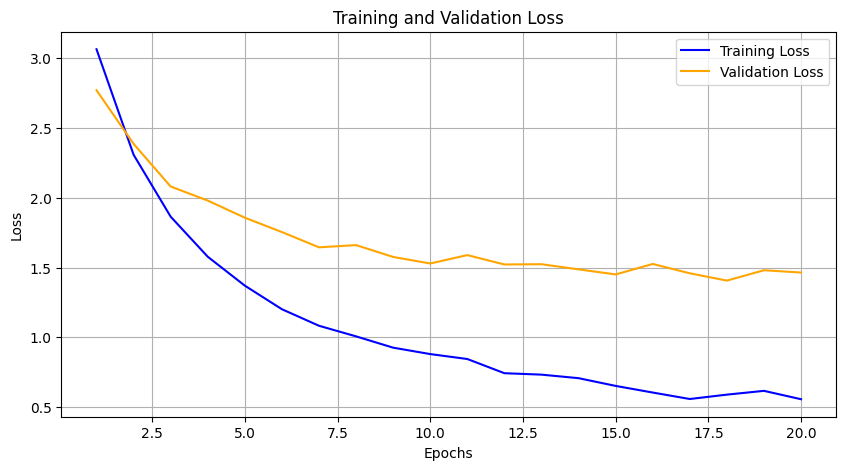

In [13]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import os

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load the pre-trained GoogleNet (Inception v1) model
model = models.googlenet(pretrained=True)  # GoogleNet is available in torchvision

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers
num_classes = 28
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Replace the final layer with 28 classes

# Move the model to the GPU
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

num_epochs = 20
train_loss_list = []  # To store training loss
val_loss_list = []    # To store validation loss
best_val_loss = float('inf')  # Initialize with infinity to track the best validation loss
best_model_path = "GoogleNetbest_model.pth"  # File to store the best model

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_list.append((epoch + 1, epoch_train_loss))  # Store epoch number and training loss
    print(f'Epoch {epoch+1} finished, Train Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:  # Use your validation loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(valid_loader)
    val_loss_list.append((epoch + 1, epoch_val_loss))  # Store epoch number and validation loss
    print(f'Epoch {epoch+1} finished, Validation Loss: {epoch_val_loss:.4f}')

    # Save the model if it has the best validation loss so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)  # Save the model's state dictionary
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Combine and save losses to a CSV file
loss_data = [(epoch, train_loss, val_loss) for (epoch, train_loss), (_, val_loss) in zip(train_loss_list, val_loss_list)]
df = pd.DataFrame(loss_data, columns=['Epoch', 'Train Loss', 'Validation Loss'])
df.to_csv('lossesGoogleNet.csv', index=False)

print("Losses saved to 'losses.csv'.")

# Plotting the losses
epochs = [epoch for epoch, _ in train_loss_list]
train_losses = [loss for _, loss in train_loss_list]
val_losses = [loss for _, loss in val_loss_list]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plot.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


# **GoogleNet Testing**

In [14]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm

# Function to calculate mAP (mean Average Precision)
def calculate_map(all_labels, all_scores, num_classes):
    mAP_scores = []
    for c in range(num_classes):
        true_labels = (all_labels == c).astype(int)
        pred_scores = all_scores[:, c]  # Scores for class c

        # Handle case where there are no positive samples
        if true_labels.sum() == 0:
            mAP_scores.append(0.0)
            continue

        ap = average_precision_score(true_labels, pred_scores)
        mAP_scores.append(ap)

    mAP = np.mean(mAP_scores)
    return mAP

# Function to evaluate the model
def evaluate_model(model, test_loader, num_classes, model_path=None):
    # Load the best model if the path is provided
    if model_path is not None:
        print(f"Loading the best model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)

    model.eval()  # Set model to evaluation mode
    top1_correct = 0
    top5_correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)  # Move images to the GPU
            labels = labels.to(device)  # Move labels to the GPU

            outputs = model(images)  # Forward pass

            # Get predicted class probabilities
            pred_scores = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)

            # Get class predictions
            _, predicted = torch.max(outputs, 1)  # Shape: (batch_size,)

            # Top-1 accuracy
            top1_correct += (predicted == labels).sum().item()
            # Top-5 accuracy
            _, top5_pred = torch.topk(outputs, 5, dim=1)
            top5_correct += (top5_pred == labels.view(-1, 1).expand_as(top5_pred)).sum().item()

            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_scores.append(pred_scores.cpu().numpy())  # Append the scores

    # Calculate accuracies
    top1_accuracy = (top1_correct / total) * 100
    top5_accuracy = (top5_correct / total) * 100

    # Concatenate all predicted scores into a 2D array
    all_scores = np.concatenate(all_scores)  # Shape: (num_samples, num_classes)

    # Calculate mean Average Precision (mAP)
    mAP = calculate_map(np.array(all_labels), all_scores, num_classes)

    print(f'Top-1 Accuracy: {top1_accuracy:.4f}')
    print(f'Top-5 Accuracy: {top5_accuracy:.4f}')
    print(f'mAP: {mAP:.4f}')

    return {
        'Top-1 Accuracy': top1_accuracy,
        'Top-5 Accuracy': top5_accuracy,
        'mAP': mAP,
    }

# Example usage
best_model_path = 'GoogleNetbest_model.pth'  # Path where the best model is saved
results = evaluate_model(model, test_loader, num_classes=28, model_path=best_model_path)

# Print evaluation results
for metric, value in results.items():
    print(f'{metric}: {value:.4f}')


<ipython-input-14-722917031254>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Loading the best model from GoogleNetbest_model.pth


100%|██████████| 11/11 [00:01<00:00,  5.68it/s]


Top-1 Accuracy: 65.2582
Top-5 Accuracy: 93.4272
mAP: 0.7198
Top-1 Accuracy: 65.2582
Top-5 Accuracy: 93.4272
mAP: 0.7198


# **EffiecientNet Training**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 193MB/s]


Epoch 1 finished, Train Loss: 2.8999
Epoch 1 finished, Validation Loss: 2.5660
Best model saved with validation loss: 2.5660
Epoch 2 finished, Train Loss: 1.9901
Epoch 2 finished, Validation Loss: 2.1336
Best model saved with validation loss: 2.1336
Epoch 3 finished, Train Loss: 1.5054
Epoch 3 finished, Validation Loss: 1.8865
Best model saved with validation loss: 1.8865
Epoch 4 finished, Train Loss: 1.2595
Epoch 4 finished, Validation Loss: 1.7820
Best model saved with validation loss: 1.7820
Epoch 5 finished, Train Loss: 1.1092
Epoch 5 finished, Validation Loss: 1.7041
Best model saved with validation loss: 1.7041
Epoch 6 finished, Train Loss: 1.0335
Epoch 6 finished, Validation Loss: 1.5290
Best model saved with validation loss: 1.5290
Epoch 7 finished, Train Loss: 0.9556
Epoch 7 finished, Validation Loss: 1.5317
Epoch 8 finished, Train Loss: 0.8715
Epoch 8 finished, Validation Loss: 1.4672
Best model saved with validation loss: 1.4672
Epoch 9 finished, Train Loss: 0.7696
Epoch 9 f

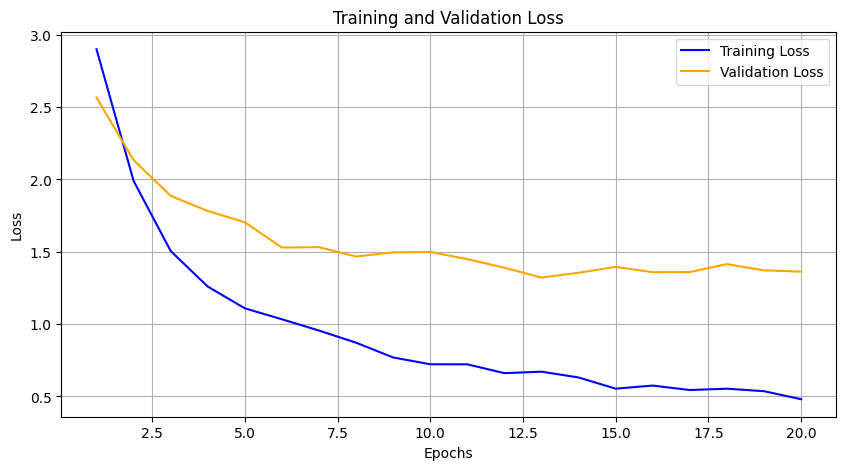

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import os

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained EfficientNet model (EfficientNet-B0 is used here)
model = models.efficientnet_b0(pretrained=True)  # Use efficientnet_b0 to efficientnet_b7 for different sizes

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify the final fully connected layer for 28 output classes
num_classes = 28
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)  # Replace the classifier

# Move the model to the GPU
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

num_epochs = 20
train_loss_list = []  # To store training loss
val_loss_list = []    # To store validation loss
best_val_loss = float('inf')  # Initialize with infinity to track the best validation loss
best_model_path = "EfficientNetbest_model.pth"  # File to store the best model

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_list.append((epoch + 1, epoch_train_loss))  # Store epoch number and training loss
    print(f'Epoch {epoch+1} finished, Train Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:  # Use your validation loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(valid_loader)
    val_loss_list.append((epoch + 1, epoch_val_loss))  # Store epoch number and validation loss
    print(f'Epoch {epoch+1} finished, Validation Loss: {epoch_val_loss:.4f}')

    # Save the model if it has the best validation loss so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)  # Save the model's state dictionary
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Combine and save losses to a CSV file
loss_data = [(epoch, train_loss, val_loss) for (epoch, train_loss), (_, val_loss) in zip(train_loss_list, val_loss_list)]
df = pd.DataFrame(loss_data, columns=['Epoch', 'Train Loss', 'Validation Loss'])
df.to_csv('lossesEfficientNet.csv', index=False)

print("Losses saved to 'losses.csv'.")

# Plotting the losses
epochs = [epoch for epoch, _ in train_loss_list]
train_losses = [loss for _, loss in train_loss_list]
val_losses = [loss for _, loss in val_loss_list]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plot.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


# **EffiecientNet Testing**

In [16]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm

# Function to calculate mAP (mean Average Precision)
def calculate_map(all_labels, all_scores, num_classes):
    mAP_scores = []
    for c in range(num_classes):
        true_labels = (all_labels == c).astype(int)
        pred_scores = all_scores[:, c]  # Scores for class c

        # Handle case where there are no positive samples
        if true_labels.sum() == 0:
            mAP_scores.append(0.0)
            continue

        ap = average_precision_score(true_labels, pred_scores)
        mAP_scores.append(ap)

    mAP = np.mean(mAP_scores)
    return mAP

# Function to evaluate the model
def evaluate_model(model, test_loader, num_classes, model_path=None):
    # Load the best model if the path is provided
    if model_path is not None:
        print(f"Loading the best model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)

    model.eval()  # Set model to evaluation mode
    top1_correct = 0
    top5_correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)  # Move images to the GPU
            labels = labels.to(device)  # Move labels to the GPU

            outputs = model(images)  # Forward pass

            # Get predicted class probabilities
            pred_scores = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)

            # Get class predictions
            _, predicted = torch.max(outputs, 1)  # Shape: (batch_size,)

            # Top-1 accuracy
            top1_correct += (predicted == labels).sum().item()
            # Top-5 accuracy
            _, top5_pred = torch.topk(outputs, 5, dim=1)
            top5_correct += (top5_pred == labels.view(-1, 1).expand_as(top5_pred)).sum().item()

            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_scores.append(pred_scores.cpu().numpy())  # Append the scores

    # Calculate accuracies
    top1_accuracy = (top1_correct / total) * 100
    top5_accuracy = (top5_correct / total) * 100

    # Concatenate all predicted scores into a 2D array
    all_scores = np.concatenate(all_scores)  # Shape: (num_samples, num_classes)

    # Calculate mean Average Precision (mAP)
    mAP = calculate_map(np.array(all_labels), all_scores, num_classes)

    print(f'Top-1 Accuracy: {top1_accuracy:.4f}')
    print(f'Top-5 Accuracy: {top5_accuracy:.4f}')
    print(f'mAP: {mAP:.4f}')

    return {
        'Top-1 Accuracy': top1_accuracy,
        'Top-5 Accuracy': top5_accuracy,
        'mAP': mAP,
    }

# Example usage
best_model_path = 'EfficientNetbest_model.pth'  # Path where the best model is saved
results = evaluate_model(model, test_loader, num_classes=28, model_path=best_model_path)

# Print evaluation results
for metric, value in results.items():
    print(f'{metric}: {value:.4f}')


<ipython-input-16-53f674ed84d5>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Loading the best model from EfficientNetbest_model.pth


100%|██████████| 11/11 [00:01<00:00,  6.65it/s]

Top-1 Accuracy: 61.9718
Top-5 Accuracy: 94.3662
mAP: 0.7034
Top-1 Accuracy: 61.9718
Top-5 Accuracy: 94.3662
mAP: 0.7034


# **DenseNet Training**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 96.4MB/s]


Epoch 1 finished, Train Loss: 2.9195
Epoch 1 finished, Validation Loss: 2.5324
Best model saved with validation loss: 2.5324
Epoch 2 finished, Train Loss: 1.8164
Epoch 2 finished, Validation Loss: 1.9473
Best model saved with validation loss: 1.9473
Epoch 3 finished, Train Loss: 1.2844
Epoch 3 finished, Validation Loss: 1.5154
Best model saved with validation loss: 1.5154
Epoch 4 finished, Train Loss: 0.9895
Epoch 4 finished, Validation Loss: 1.4376
Best model saved with validation loss: 1.4376
Epoch 5 finished, Train Loss: 0.7963
Epoch 5 finished, Validation Loss: 1.2777
Best model saved with validation loss: 1.2777
Epoch 6 finished, Train Loss: 0.6713
Epoch 6 finished, Validation Loss: 1.2042
Best model saved with validation loss: 1.2042
Epoch 7 finished, Train Loss: 0.5908
Epoch 7 finished, Validation Loss: 1.1452
Best model saved with validation loss: 1.1452
Epoch 8 finished, Train Loss: 0.5421
Epoch 8 finished, Validation Loss: 1.0612
Best model saved with validation loss: 1.0612


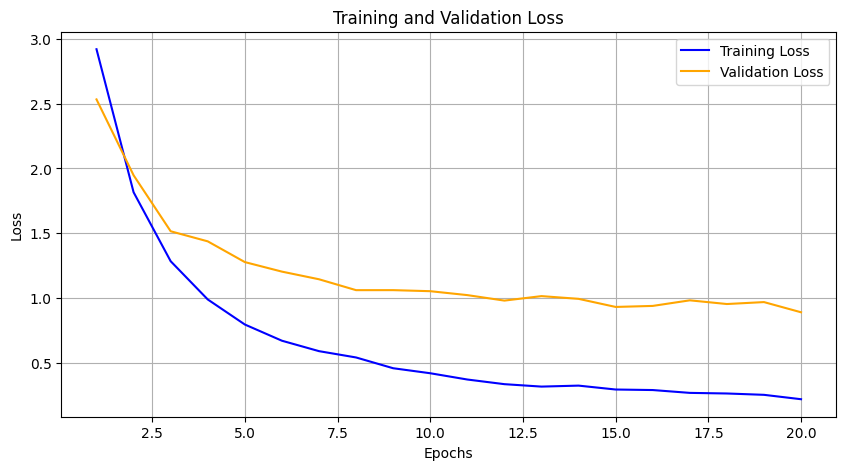

In [17]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import os

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained DenseNet model (DenseNet121 is used here)
model = models.densenet121(pretrained=True)  # You can also use densenet169, densenet201

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify the final fully connected layer for 28 output classes
num_classes = 28
model.classifier = nn.Linear(model.classifier.in_features, num_classes)  # Replace the classifier

# Move the model to the GPU
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

num_epochs = 20
train_loss_list = []  # To store training loss
val_loss_list = []    # To store validation loss
best_val_loss = float('inf')  # Initialize with infinity to track the best validation loss
best_model_path = "DenseNetbest_model.pth"  # File to store the best model

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_list.append((epoch + 1, epoch_train_loss))  # Store epoch number and training loss
    print(f'Epoch {epoch+1} finished, Train Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:  # Use your validation loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(valid_loader)
    val_loss_list.append((epoch + 1, epoch_val_loss))  # Store epoch number and validation loss
    print(f'Epoch {epoch+1} finished, Validation Loss: {epoch_val_loss:.4f}')

    # Save the model if it has the best validation loss so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)  # Save the model's state dictionary
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Combine and save losses to a CSV file
loss_data = [(epoch, train_loss, val_loss) for (epoch, train_loss), (_, val_loss) in zip(train_loss_list, val_loss_list)]
df = pd.DataFrame(loss_data, columns=['Epoch', 'Train Loss', 'Validation Loss'])
df.to_csv('lossesDenseNet.csv', index=False)

print("Losses saved to 'losses.csv'.")

# Plotting the losses
epochs = [epoch for epoch, _ in train_loss_list]
train_losses = [loss for _, loss in train_loss_list]
val_losses = [loss for _, loss in val_loss_list]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plot.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


# **DenseNet Testing**

In [18]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm

# Function to calculate mAP (mean Average Precision)
def calculate_map(all_labels, all_scores, num_classes):
    mAP_scores = []
    for c in range(num_classes):
        true_labels = (all_labels == c).astype(int)
        pred_scores = all_scores[:, c]  # Scores for class c

        # Handle case where there are no positive samples
        if true_labels.sum() == 0:
            mAP_scores.append(0.0)
            continue

        ap = average_precision_score(true_labels, pred_scores)
        mAP_scores.append(ap)

    mAP = np.mean(mAP_scores)
    return mAP

# Function to evaluate the model
def evaluate_model(model, test_loader, num_classes, model_path=None):
    # Load the best model if the path is provided
    if model_path is not None:
        print(f"Loading the best model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)

    model.eval()  # Set model to evaluation mode
    top1_correct = 0
    top5_correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)  # Move images to the GPU
            labels = labels.to(device)  # Move labels to the GPU

            outputs = model(images)  # Forward pass

            # Get predicted class probabilities
            pred_scores = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)

            # Get class predictions
            _, predicted = torch.max(outputs, 1)  # Shape: (batch_size,)

            # Top-1 accuracy
            top1_correct += (predicted == labels).sum().item()
            # Top-5 accuracy
            _, top5_pred = torch.topk(outputs, 5, dim=1)
            top5_correct += (top5_pred == labels.view(-1, 1).expand_as(top5_pred)).sum().item()

            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_scores.append(pred_scores.cpu().numpy())  # Append the scores

    # Calculate accuracies
    top1_accuracy = (top1_correct / total) * 100
    top5_accuracy = (top5_correct / total) * 100

    # Concatenate all predicted scores into a 2D array
    all_scores = np.concatenate(all_scores)  # Shape: (num_samples, num_classes)

    # Calculate mean Average Precision (mAP)
    mAP = calculate_map(np.array(all_labels), all_scores, num_classes)

    print(f'Top-1 Accuracy: {top1_accuracy:.4f}')
    print(f'Top-5 Accuracy: {top5_accuracy:.4f}')
    print(f'mAP: {mAP:.4f}')

    return {
        'Top-1 Accuracy': top1_accuracy,
        'Top-5 Accuracy': top5_accuracy,
        'mAP': mAP,
    }

# Example usage
best_model_path = 'DenseNetbest_model.pth'  # Path where the best model is saved
results = evaluate_model(model, test_loader, num_classes=28, model_path=best_model_path)

# Print evaluation results
for metric, value in results.items():
    print(f'{metric}: {value:.4f}')


<ipython-input-18-cba570abb92d>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Loading the best model from DenseNetbest_model.pth


100%|██████████| 11/11 [00:01<00:00,  6.72it/s]

Top-1 Accuracy: 77.4648
Top-5 Accuracy: 98.1221
mAP: 0.8667
Top-1 Accuracy: 77.4648
Top-5 Accuracy: 98.1221
mAP: 0.8667
